# Semantic Segmentation with Keras

In this exercise, you'll use the U-Net network to perform binary classification and segmentation for images of planes.

## Install Keras

To begin with, we'll install the latest version of Keras.

In [1]:
!pip install --upgrade keras

Requirement already up-to-date: keras in /data/anaconda/envs/py35/lib/python3.5/site-packages (2.2.4)
You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Import the U-Net Code

The code to implement U-Net is provided in two python files:

- **model.py**: This file contains the code that implements the U-Net model
- **data.py**: This file contains functions to help load and prepare training data.

> **Tip**: You should explore the code in these files to get a better understanding of the way the model works.


In [2]:
from unet_keras.data import *
from unet_keras.model import *

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Explore the Training Data

The training data for a U-Net model consists of two kinds of input:

- **Image files**: The images that represent the *features* on which we want to train the model.
- **Mask files**: Images of the object masks that the network will be trained to predict - these are the *labels*.

In this example, we're going to use U-Net for binary classification of airplanes images, so there's only one class of object - and therefore one class of mask. We've deliberately made this example as simple as possible, partly to make it easier to understand what's going on, and partly to ensure it can be run in a resource-constrained environment. 

Let's take a look at the training images and masks:

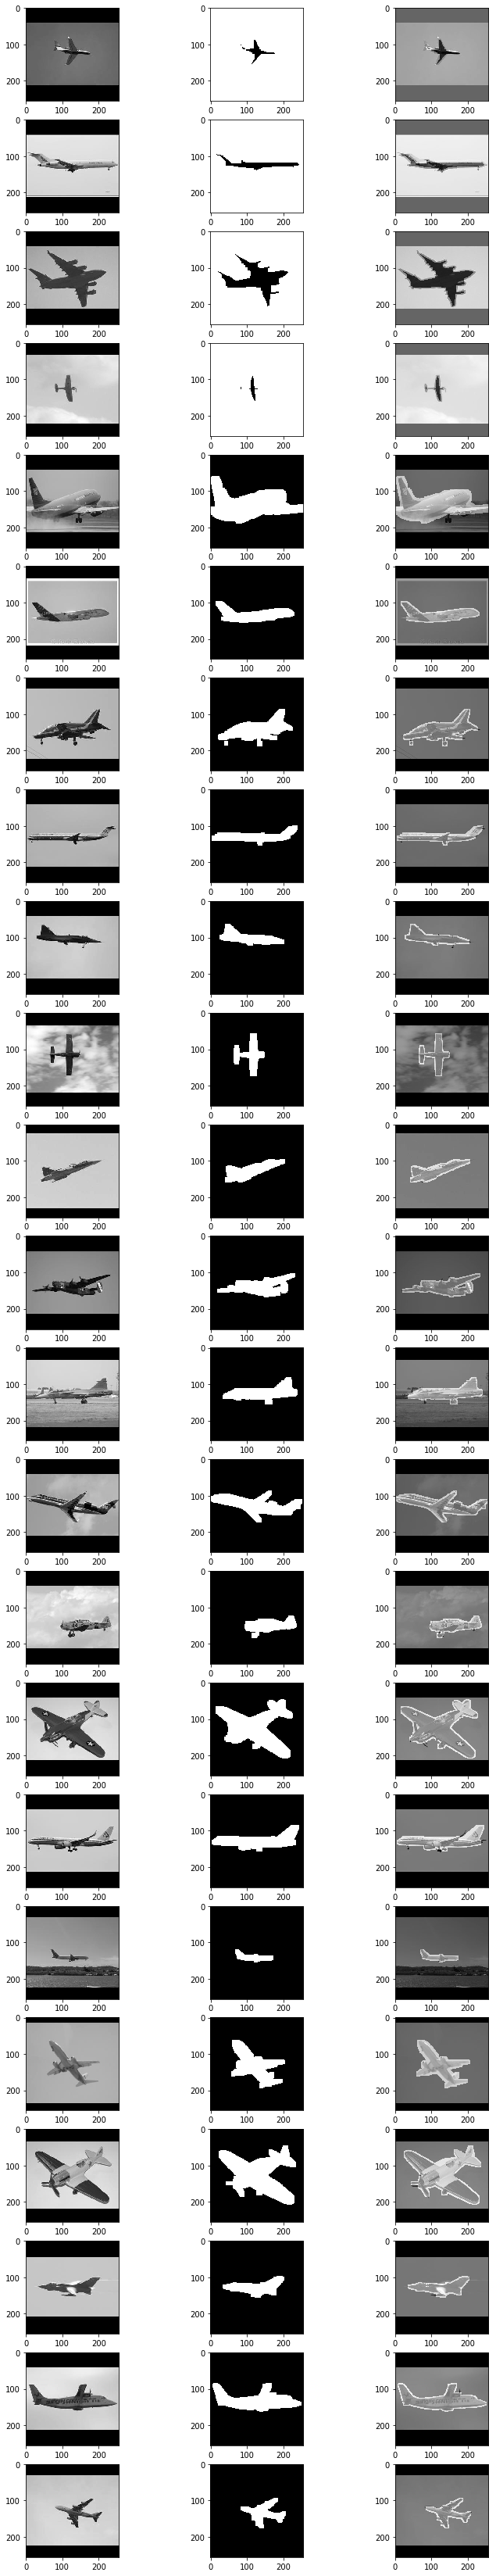

In [3]:
import os
from matplotlib import pyplot as plt
import skimage.io as io
import numpy as np
%matplotlib inline


fig = plt.figure(figsize=(12, 60))


train_dir = 'data/train'
image_dir = os.path.join(train_dir,"image/plane")
mask_dir = os.path.join(train_dir,"mask/plane")

files = os.listdir(image_dir)
rows = len(files)
cell = 0
for file in files:
    cell += 1
    
    # Open the image and mask files
    img_path = os.path.join(image_dir, file)
    img = io.imread(img_path, as_gray = True)
    
    mask_path = os.path.join(mask_dir, file)
    mask = io.imread(mask_path, as_gray = True)
    
    # plot the image
    a=fig.add_subplot(rows,3,cell)
    imgplot=plt.imshow(img, "gray")
    cell += 1

    # plot the mask
    a=fig.add_subplot(rows,3,cell)
    imgplot=plt.imshow(mask, "gray")
    cell += 1
    
    # Plot them overlaid
    a=fig.add_subplot(rows,3,cell)
    imgplot=plt.imshow(img, "gray")
    imgplot=plt.imshow(mask, "gray", alpha=0.4)

plt.show()



The ouput from the code above shows the training images with their corresponding mask labels, and finally the mask overlaid on the image so you can clearly see that the masks represent the pixels that belong to the plane objects in the images.

> **Note**: We also deliberately chose images in which the plane objects are clearly contrasted with the background to make it easier to train with a very small number of training images.

## Load the Training Data
We have a very small number of training images, so we'll apply some data augmentation to randomly flip, zoom, shear, and otherwise transform the images for each batch.

In [4]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
train_images = trainGenerator(2,'data/train/','image','mask',data_gen_args,save_to_dir = None)

## Train the Model

Now we're ready to train the U-Net model. We'll train it from the training generator we created, and save the model weights after each epoch if the loss has improved.

In [5]:
model = unet()
model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit_generator(train_images,steps_per_epoch=500,epochs=10,callbacks=[model_checkpoint])

Epoch 1/10
Found 22 images belonging to 1 classes.
Found 22 images belonging to 1 classes.
500/500 [==============================] - 227s 453ms/step - loss: 0.1178 - acc: 0.9565

Epoch 00001: loss improved from inf to 0.11776, saving model to unet.hdf5
Epoch 2/10
500/500 [==============================] - 221s 442ms/step - loss: 0.0465 - acc: 0.9820

Epoch 00002: loss improved from 0.11776 to 0.04654, saving model to unet.hdf5
Epoch 3/10
500/500 [==============================] - 221s 442ms/step - loss: 0.0206 - acc: 0.9916

Epoch 00003: loss improved from 0.04654 to 0.02058, saving model to unet.hdf5
Epoch 4/10
500/500 [==============================] - 221s 441ms/step - loss: 0.0469 - acc: 0.9839

Epoch 00004: loss did not improve from 0.02058
Epoch 5/10
500/500 [==============================] - 220s 440ms/step - loss: 0.0560 - acc: 0.9789

Epoch 00005: loss did not improve from 0.02058
Epoch 6/10
500/500 [==============================] - 220s 440ms/step - loss: 0.0235 - acc: 0.99

## Test the Trained Model

OK, let's see how well our trained model does with some images of airplanes it hasn't seen.

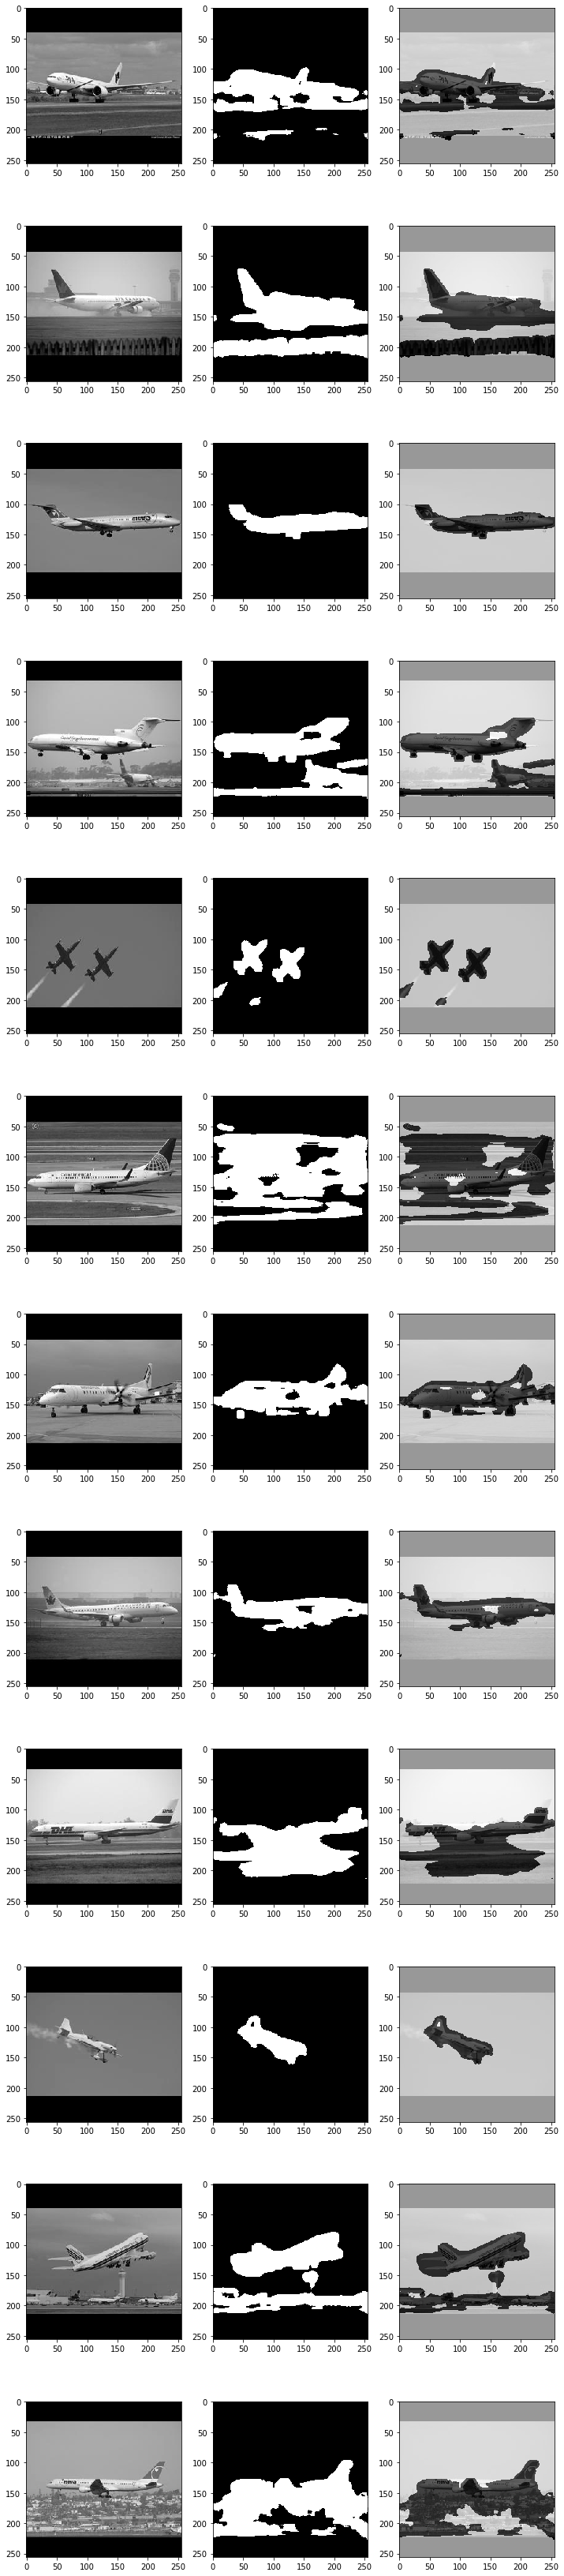

In [6]:
import os
from matplotlib import pyplot as plt
import skimage.io as io
import numpy as np
%matplotlib inline

model = unet()
model.load_weights("unet.hdf5")

fig = plt.figure(figsize=(12, 60))


imgdir = 'data/plane_png/test'

files = os.listdir(imgdir)
rows = len(files)
cell = 0
for file in files:
    cell += 1
    # Open the file
    img_path = os.path.join(imgdir, file)
    img = io.imread(img_path, as_gray = True)
    
    src_img = img
    a=fig.add_subplot(rows,3,cell)
    imgplot=plt.imshow(src_img, "gray")
    cell += 1

    img = np.reshape(img,img.shape+(1,))
    mask_predictions = model.predict([[img]])
    mask = mask_predictions[0]
    img_mask = mask.reshape(mask.shape[0], mask.shape[1])

    a=fig.add_subplot(rows,3,cell)
    imgplot=plt.imshow(img_mask, "gray")
    cell += 1


    a=fig.add_subplot(rows,3,cell)
    imgplot=plt.imshow(src_img, "gray")
    imgplot=plt.imshow(img_mask, "binary", alpha=0.6)

plt.show()



It's not fantastic, largely because we used such a small amount of data; but hopefully it serves to demonstrate the principles of semantic segmentaion with U-Net.

## Citations

The U-Net architecture is documented by its inventors (Olaf Ronneberger, Philipp Fischer, and Thomas Brox), at https://arxiv.org/abs/1505.04597.

The Keras implementation of U-Net used in this exercise is based on zhixuhao's work at https://github.com/zhixuhao/unet, with some simplifications. 

The data used in this exercise includes images adapted from the PASCAL Visual Object Classes Challenge (VOC2007) dataset at http://host.robots.ox.ac.uk/pascal/VOC/voc2007/.


    @misc{pascal-voc-2007,
        author = "Everingham, M. and Van~Gool, L. and Williams, C. K. I. and Winn, J. and Zisserman, A.",
        title = "The {PASCAL} {V}isual {O}bject {C}lasses {C}hallenge 2007 {(VOC2007)} {R}esults",
        howpublished = "http://www.pascal-network.org/challenges/VOC/voc2007/workshop/index.html"}

